In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import time

from ml_model_lstm_best import run_model
from ml_model_lstm_best import long_only_strategy_daily
from ml_model_lstm_best import long_only_strategy_monthly
from  matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
import tensorflow
print (tensorflow.__version__)

1.14.0


In [4]:
df = pd.read_csv('data/analysis_model_ready_0721.csv')

In [5]:
df.head()

,paper_month,ticker,total_count,total_count_cumsum,total_citation,total_citation_cumsum,patent_count,patent_count_cumsum,patent_citation,patent_citation_cumsum,...,ps,pb,eps,roa,roe,npm,quick,current,debt_equity,forward_monthly_return
0,2002-04,AAPL,2,391,92,7829,1,261,78,5314,...,5.606148,2.087990,0.11,0.006386,0.009965,0.026756,3.152721,3.167934,0.560538,-0.039967
1,2002-04,ACN,1,94,34,878,0,48,33,660,...,2.665986,10.699305,0.03,0.002041,0.040544,0.003188,1.283192,1.283192,16.696321,-0.027519
2,2002-04,ADBE,1,138,19,870,1,128,19,829,...,32.316759,12.556044,0.21,0.050314,0.072237,0.185923,2.750059,2.750059,0.435716,-0.096597
3,2002-04,ADI,0,11,0,60,0,4,0,54,...,40.672941,5.543896,0.07,0.005023,0.008564,0.062829,6.380681,6.853139,0.704922,-0.009199
4,2002-04,ADSK,0,77,9,471,0,64,9,378,...,8.980703,4.310115,0.39,0.024122,0.041127,0.085693,1.472736,1.521296,0.704931,-0.265905


In [6]:
df.shape

(15990, 61)

In [7]:
df['monthly_return'] = df.forward_monthly_return

In [8]:
df.columns

Index(['paper_month', 'ticker', 'total_count', 'total_count_cumsum',
       'total_citation', 'total_citation_cumsum', 'patent_count',
       'patent_count_cumsum', 'patent_citation', 'patent_citation_cumsum',
       'journal_count', 'journal_count_cumsum', 'journal_citation',
       'journal_citation_cumsum', 'conference_count',
       'conference_count_cumsum', 'conference_citation',
       'conference_citation_cumsum', 'Books_count', 'Books_count_cumsum',
       'Books_citation', 'Books_citation_cumsum', 'total_average_citation',
       'total_max_citation', 'patent_average_citation', 'patent_max_citation',
       'journal_average_citation', 'journal_max_citation',
       'conference_average_citation', 'conference_max_citation',
       'Books_average_citation', 'Books_max_citation', 'total_count_relative',
       'total_count_relative_cumsum', 'patent_count_relative',
       'patent_count_relative_cumsum', 'journal_count_relative',
       'journal_count_relative_cumsum', 'conference

In [9]:
features_column_alternative =[
       'total_count', 'total_count_cumsum',
       'total_citation', 'total_citation_cumsum', 'patent_count',
       'patent_count_cumsum', 'patent_citation', 'patent_citation_cumsum',
       'journal_count', 'journal_count_cumsum', 'journal_citation',
       'journal_citation_cumsum', 'conference_count',
       'conference_count_cumsum', 'conference_citation',
       'conference_citation_cumsum', 'Books_count', 'Books_count_cumsum',
       'Books_citation', 'Books_citation_cumsum', 'total_average_citation',
       'total_max_citation', 'patent_average_citation', 'patent_max_citation',
       'journal_average_citation', 'journal_max_citation',
       'conference_average_citation', 'conference_max_citation',
       'Books_average_citation', 'Books_max_citation', 'total_count_relative',
       'total_count_relative_cumsum', 'patent_count_relative',
       'patent_count_relative_cumsum', 'journal_count_relative',
       'journal_count_relative_cumsum', 'conference_count_relative',
       'conference_count_relative_cumsum', 'Books_count_relative',
       'Books_count_relative_cumsum'
]

In [10]:
len(features_column_alternative)

40

In [11]:
features_column_financial=['pe', 'ps', 'pb', 'eps', 'roa', 'roe',
       'npm', 'quick', 'current', 'debt_equity']

In [12]:
len(features_column_financial)

10

In [13]:
features_column_all = features_column_alternative+features_column_financial

In [14]:
len(features_column_all)

50

# Prepare Data

## 1. Get Unique Ticker

In [15]:
unique_ticker = sorted(df.ticker.unique())

In [16]:
len(unique_ticker)

104

## 2. Get Unique Datatime (monthly)

In [17]:
df.date=pd.to_datetime(df['date'])

unique_datetime=[x.strftime("%Y-%m-%d") for x in df.date.dt.date.unique()]

In [18]:
len(unique_datetime)

196

In [19]:
len(unique_datetime)/12

16.333333333333332

In [20]:
unique_datetime[42]

'2005-11-30'

In [21]:
 '2005-01-31'

'2005-01-31'

In [22]:
#unique_datetime

## 3. Get Trade Month

In [23]:
trade_month = unique_datetime[42:]

In [24]:
#trade_month

In [25]:
len(trade_month)

154

In [26]:
len(trade_month)/12

12.833333333333334

In [27]:
df.shape[0]/154

103.83116883116882

## 4. Get tic Monthly Return

In [28]:
tic_monthly_return=df.pivot('date','ticker','monthly_return')
tic_monthly_return=tic_monthly_return.reset_index()
tic_monthly_return.index=tic_monthly_return.date
del tic_monthly_return['date']

In [29]:
tic_monthly_return.head()

ticker,AAPL,ACN,ADBE,ADI,ADSK,AKAM,AMAT,AMD,AMKR,AMZN,...,TER,TXN,UIS,V,VECO,VMW,VRSN,VSAT,XLNX,XRX
date,,,,,,,,,,,,,,,,,,,,,
2002-04-30,-0.039967,-0.027519,-0.096597,-0.009199,-0.265905,NaN,-0.087993,0.022361,NaN,0.092271,...,-0.178149,-0.073068,-0.152593,NaN,-0.016504,NaN,NaN,NaN,-0.066208,0.013559
2002-05-31,-0.239485,-0.088729,-0.210526,-0.188968,-0.018519,NaN,-0.142471,-0.149606,-0.581708,-0.108612,...,-0.132201,-0.173352,-0.213287,NaN,-0.206959,NaN,NaN,NaN,-0.363868,-0.222965
2002-06-28,-0.138826,-0.131579,-0.159298,-0.188552,-0.027170,NaN,-0.218191,-0.173868,-0.366559,-0.110215,...,-0.361702,-0.023207,-0.164444,NaN,-0.411510,NaN,NaN,NaN,-0.144449,-0.002869
2002-07-31,-0.033421,-0.003030,-0.161102,0.000000,0.031808,NaN,-0.101547,0.102117,-0.428934,0.033266,...,-0.156667,-0.149028,0.183511,NaN,-0.036765,NaN,NaN,NaN,0.006774,0.008633
2002-08-30,-0.016949,-0.131915,-0.049751,-0.182573,-0.047368,NaN,-0.135479,-0.396610,0.057778,0.066265,...,-0.241107,-0.250254,-0.213483,NaN,-0.175573,NaN,NaN,NaN,-0.180228,-0.293866


In [30]:
tic_monthly_return=tic_monthly_return[tic_monthly_return.index>=unique_datetime[42]]

In [31]:
tic_monthly_return.shape

(154, 104)

## 5. Get Equally Portfolio Monthly Return

## 6. Get Daily price

In [32]:
#daily_price = pd.read_csv("data/adj_close_price_2002_2018.csv")
#daily_price = daily_price.pivot('date', 'tic', 'adj_close')
#daily_price=daily_price[unique_ticker]
#daily_price.to_excel('data/daily_price.xlsx','Sheet1')

In [33]:
'''
daily_price = pd.read_csv("data/adj_close_price_2002_2018_0721.csv")
daily_price = daily_price.pivot('date', 'tic', 'adj_close')
daily_price=daily_price[unique_ticker]
#daily_return = (daily_price.shift(-1)-daily_price)/daily_price
daily_return=daily_price.pct_change()
daily_return = daily_return[daily_return.index>=trade_month[0]]
daily_return.to_excel('data/daily_return_0721.xlsx','Sheet1')'''


'\ndaily_price = pd.read_csv("data/adj_close_price_2002_2018_0721.csv")\ndaily_price = daily_price.pivot(\'date\', \'tic\', \'adj_close\')\ndaily_price=daily_price[unique_ticker]\n#daily_return = (daily_price.shift(-1)-daily_price)/daily_price\ndaily_return=daily_price.pct_change()\ndaily_return = daily_return[daily_return.index>=trade_month[0]]\ndaily_return.to_excel(\'data/daily_return_0721.xlsx\',\'Sheet1\')'

In [34]:
daily_return=pd.read_excel('data/daily_return_0721.xlsx','Sheet1',index_col=0)

In [35]:
daily_return.head()

,AAPL,ACN,ADBE,ADI,ADSK,AKAM,AMAT,AMD,AMKR,AMZN,...,TER,TXN,UIS,V,VECO,VMW,VRSN,VSAT,XLNX,XRX
date,,,,,,,,,,,,,,,,,,,,,
2005-11-30,-0.004112,0.007082,0.006481,0.017713,0.011625,0.010121,-0.002753,0.023456,0.024793,-0.001854,...,0.028110,0.019460,0.004902,NaN,0.014900,NaN,0.005427,0.002175,0.019668,0.002117
2005-12-01,0.055737,0.024613,0.038945,0.035074,0.003831,0.054609,0.029266,0.046982,0.056452,0.011143,...,0.079289,0.042180,0.008130,NaN,0.033879,NaN,0.019793,0.003255,0.026853,0.041549
2005-12-02,0.014384,0.001373,0.032172,0.012484,0.011686,-0.008076,0.010193,0.019701,0.012214,0.001224,...,-0.020899,0.007681,0.014516,NaN,-0.008738,NaN,-0.006617,0.001442,0.007735,-0.017579
2005-12-05,-0.011152,-0.014051,0.008007,-0.014595,0.012494,0.006226,-0.015401,-0.024329,-0.030166,-0.004688,...,-0.001940,-0.026385,0.004769,NaN,0.000551,NaN,-0.000888,-0.003960,-0.032895,-0.004129
2005-12-06,0.031050,0.002781,0.049362,0.007150,0.015600,0.026178,0.022114,-0.011735,0.009331,0.008806,...,0.005833,0.002409,0.011076,NaN,0.020925,NaN,0.008444,-0.005421,0.019652,0.012440


In [36]:
daily_return.shape

(3321, 104)

## 7. Get Trade Month for daily return

In [37]:
trade_month_plus1=trade_month.copy()
trade_month_plus1.append('2019-01-31')

In [38]:
len(trade_month)

154

In [39]:
len(trade_month_plus1)

155

## 8. Get First Trade Date Index

In [41]:
#3 years (36 months to train), 6 months to test: total 42 months
first_trade_date_index = 42

## Run Model
* Input: Features + Forward Month Return
* Output: Monthly Stock Predicted Return 


### Alternative Data Only

In [42]:
len(features_column_alternative)

40

In [43]:
len(trade_month)

154

In [44]:
#%%time
start=time.time()
model_results= run_model(df,unique_ticker,unique_datetime,trade_month,features_column_alternative,first_trade_date_index = 150,testing_windows = 6)
end=time.time()


Epoch 1/2
 7424/10821 [===================>..........] - ETA: 2s - loss: 0.0959

KeyboardInterrupt: 

In [ ]:
(end-start)/3600

In [ ]:
0.1118

In [ ]:
0.1124

In [ ]:
0.1157

In [ ]:
0.1175

### Financial Data Only

In [ ]:
len(features_column_financial)

In [ ]:
#%%time

#model_results= run_model(df,unique_ticker,unique_datetime,trade_month,features_column_financial,first_trade_date_index = 42,testing_windows = 6)


### All Features: Alternative Data + Financial Data

In [ ]:
len(features_column_all)

In [ ]:
#%%time

#model_results= run_model(df,unique_ticker,unique_datetime,trade_month,features_column_all,first_trade_date_index = 42,testing_windows = 6)


## Output: 1. Get Predicted Return

In [ ]:
df_predict_lr = model_results[0].astype(np.float64)

df_predict_lasso = model_results[1].astype(np.float64)
df_predict_ridge = model_results[2].astype(np.float64)
df_predict_rf = model_results[3].astype(np.float64)
df_predict_svm = model_results[4].astype(np.float64)
#df_predict_gbm = model_results[5].astype(np.float64)
#df_predict_ada = model_results[5].astype(np.float64)
df_predict_lstm = model_results[5].astype(np.float64)


df_predict_best = model_results[6].astype(np.float64)
df_best_model_name = model_results[7]
df_evaluation_score = model_results[8]

In [ ]:
df_evaluation_score[0]

In [ ]:
df_predict_best.shape

In [ ]:
evaluation_list = []
for i in range(df_predict_best.shape[0]):
    evaluation_list.append(df_evaluation_score[i]['model_eval'].values)
    

In [ ]:
df_evaluation = pd.DataFrame(evaluation_list,columns = ['linear_regression', 'lasso','ridge','random_forest','svm','lstm'])
df_evaluation.index = df_predict_best.index.values

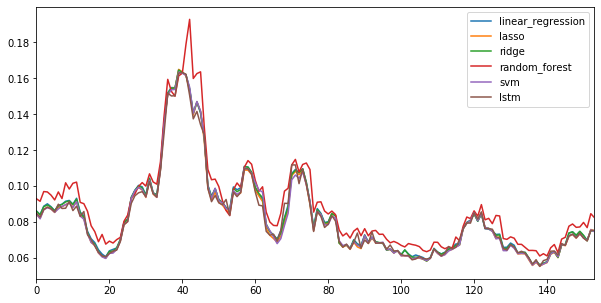

In [5]:
df_evaluation.plot(figsize=(10,5))
#plt.plot(df_evaluation)


In [7]:
df_evaluation

,Unnamed: 0,linear_regression,lasso,ridge,random_forest,svm,lstm
0,2005-11-30,0.086251,0.084325,0.086141,0.093056,0.084559,0.084991
1,2005-12-30,0.084260,0.082142,0.084075,0.091645,0.081884,0.082935
2,2006-01-31,0.088935,0.087121,0.088621,0.097074,0.086971,0.087012
3,2006-02-28,0.090260,0.088281,0.089626,0.096854,0.088064,0.088494
4,2006-03-31,0.088645,0.087402,0.088385,0.095073,0.087394,0.087549
...,...,...,...,...,...,...,...
149,2018-07-31,0.074825,0.073491,0.074965,0.077384,0.073565,0.073991
150,2018-08-31,0.072571,0.071320,0.072758,0.079888,0.071298,0.071167
151,2018-09-28,0.070056,0.069771,0.069672,0.077021,0.069814,0.069645
152,2018-10-31,0.075422,0.075979,0.075411,0.084767,0.075790,0.075311


In [ ]:
#df_evaluation_score

In [ ]:
#df_evaluation_score

In [58]:
df_best_model_name[(df_best_model_name.index>='2008-11-01')& (df_best_model_name.index<'2018-11-01')].model_name.value_counts()

lstm     41
lasso    37
svm      27
lr        6
rf        3
ridge     3
Name: model_name, dtype: int64

In [59]:
41+37+27+6+3+3

117

In [60]:
41/117

0.3504273504273504

In [61]:
37/117

0.3162393162393162

In [62]:
27/117

0.23076923076923078

In [63]:
6/117

0.05128205128205128

In [64]:
3/117

0.02564102564102564

In [65]:
3/117

0.02564102564102564

In [67]:
35+31+23+5+3+3

100

In [53]:
40+37+27+6+3+2


115

In [21]:
df_best_model_name

,model_name
2005-11-30,lasso
2005-12-30,svm
2006-01-31,svm
2006-02-28,svm
2006-03-31,svm
...,...
2018-07-31,lstm
2018-08-31,lstm
2018-09-28,ridge
2018-10-31,ridge


In [40]:
df_evaluation = pd.read_csv('results/alternative_0803_lstm_2/df_evaluation.csv',index_col=0)


In [41]:
df_best_model_name=pd.read_csv('results/alternative_0803_lstm_2/df_best_model_name.csv',index_col=0)


In [42]:
df_best_model_name

,model_name
2005-11-30,lasso
2005-12-30,svm
2006-01-31,svm
2006-02-28,svm
2006-03-31,svm
2006-04-28,lasso
2006-05-31,lstm
2006-06-30,lasso
2006-07-31,lstm
2006-08-31,lstm


In [ ]:
#df_evaluation_score


## Alternative 

In [ ]:
df_predict_best.to_csv('results/alternative_0804_lstm/df_predict_best.csv')

df_predict_lr.to_csv('results/alternative_0804_lstm/df_predict_lr.csv')
df_predict_lasso.to_csv('results/alternative_0804_lstm/df_predict_lasso.csv')
df_predict_ridge.to_csv('results/alternative_0804_lstm/df_predict_ridge.csv')
df_predict_rf.to_csv('results/alternative_0804_lstm/df_predict_rf.csv')
df_predict_svm.to_csv('results/alternative_0804_lstm/df_predict_svm.csv')
df_predict_lstm.to_csv('results/alternative_0804_lstm/df_predict_lstm.csv')
df_evaluation.to_csv('results/alternative_0804_lstm/df_evaluation.csv')
df_best_model_name.to_csv('results/alternative_0804_lstm/df_best_model_name.csv')
#df_predict_gbm.to_csv('results/alternative_0730/df_predict_gbm.csv')
#df_predict_ada.to_csv('results/alternative_0803_lstm_2/df_predict_ada.csv')



In [ ]:
#df_predict_best

## Financial

In [ ]:
df_predict_best.to_csv('results/financial_0730/df_predict_best.csv')

df_predict_lr.to_csv('results/financial_0730/df_predict_lr.csv')
df_predict_lasso.to_csv('results/financial_0730/df_predict_lasso.csv')
df_predict_ridge.to_csv('results/financial_0730/df_predict_ridge.csv')
df_predict_rf.to_csv('results/financial_0730/df_predict_rf.csv')
df_predict_svm.to_csv('results/financial_0730/df_predict_svm.csv')


df_predict_gbm.to_csv('results/financial_0730/df_predict_gbm.csv')
df_predict_ada.to_csv('results/financial_0730/df_predict_ada.csv')



## All Features

In [ ]:
df_predict_best.to_csv('results/all_features_0730/df_predict_best.csv')

df_predict_lr.to_csv('results/all_features_0730/df_predict_lr.csv')
df_predict_lasso.to_csv('results/all_features_0730/df_predict_lasso.csv')
df_predict_ridge.to_csv('results/all_features_0730/df_predict_ridge.csv')
df_predict_rf.to_csv('results/all_features_0730/df_predict_rf.csv')
df_predict_svm.to_csv('results/all_features_0730/df_predict_svm.csv')


#df_predict_gbm.to_csv('results/all_features_0730/df_predict_gbm.csv')
df_predict_ada.to_csv('results/all_features_0730/df_predict_ada.csv')



In [ ]:
#df_evaluation_score

## Output: 2. Get Portfolio Daily Return

In [43]:
df_portfolio_best_daily=long_only_strategy_daily(df_predict_best,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)


df_portfolio_lr_daily=long_only_strategy_daily(df_predict_lr,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_lasso_daily=long_only_strategy_daily(df_predict_lasso,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_ridge_daily=long_only_strategy_daily(df_predict_ridge,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_rf_daily=long_only_strategy_daily(df_predict_rf,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_svm_daily=long_only_strategy_daily(df_predict_svm,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_lstm_daily=long_only_strategy_daily(df_predict_lstm,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)

#df_portfolio_gbm_daily=long_only_strategy_daily(df_predict_gbm,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
#df_portfolio_ada_daily=long_only_strategy_daily(df_predict_ada,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)



NameError: name 'df_predict_best' is not defined

In [ ]:
#df_predict_best[df_predict_best.index<='2018-08-31']

## Alternative

In [ ]:
df_portfolio_best_daily.to_csv('results/alternative_0804_lstm/df_portfolio_best_daily.csv')


df_portfolio_lr_daily.to_csv('results/alternative_0804_lstm/df_portfolio_lr_daily.csv')
df_portfolio_lasso_daily.to_csv('results/alternative_0804_lstm/df_portfolio_lasso_daily.csv')
df_portfolio_ridge_daily.to_csv('results/alternative_0804_lstm/df_portfolio_ridge_daily.csv')
df_portfolio_rf_daily.to_csv('results/alternative_0804_lstm/df_portfolio_rf_daily.csv')
df_portfolio_svm_daily.to_csv('results/alternative_0804_lstm/df_portfolio_svm_daily.csv')
df_portfolio_lstm_daily.to_csv('results/alternative_0804_lstm/df_portfolio_lstm_daily.csv')

#df_portfolio_gbm_daily.to_csv('results/alternative_0730/df_portfolio_gbm_daily.csv')
#df_portfolio_ada_daily.to_csv('results/alternative_0803_lstm_2/df_portfolio_ada_daily.csv')


## Financial

In [ ]:
df_portfolio_best_daily.to_csv('results/financial_0730/df_portfolio_best_daily.csv')


df_portfolio_lr_daily.to_csv('results/financial_0730/df_portfolio_lr_daily.csv')
df_portfolio_lasso_daily.to_csv('results/financial_0730/df_portfolio_lasso_daily.csv')
df_portfolio_ridge_daily.to_csv('results/financial_0730/df_portfolio_ridge_daily.csv')
df_portfolio_rf_daily.to_csv('results/financial_0730/df_portfolio_rf_daily.csv')
df_portfolio_svm_daily.to_csv('results/financial_0730/df_portfolio_svm_daily.csv')


df_portfolio_gbm_daily.to_csv('results/financial_0730/df_portfolio_gbm_daily.csv')
df_portfolio_ada_daily.to_csv('results/financial_0730/df_portfolio_ada_daily.csv')


## All Features

In [ ]:
df_portfolio_best_daily.to_csv('results/all_features_0730/df_portfolio_best_daily.csv')


df_portfolio_lr_daily.to_csv('results/all_features_0730/df_portfolio_lr_daily.csv')
df_portfolio_lasso_daily.to_csv('results/all_features_0730/df_portfolio_lasso_daily.csv')
df_portfolio_ridge_daily.to_csv('results/all_features_0730/df_portfolio_ridge_daily.csv')
df_portfolio_rf_daily.to_csv('results/all_features_0730/df_portfolio_rf_daily.csv')
df_portfolio_svm_daily.to_csv('results/all_features_0730/df_portfolio_svm_daily.csv')


df_portfolio_gbm_daily.to_csv('results/all_features_0730/df_portfolio_gbm_daily.csv')
df_portfolio_ada_daily.to_csv('results/all_features_0730/df_portfolio_ada_daily.csv')


In [ ]:
type(df_portfolio_best_daily)

In [ ]:
df_portfolio_best_daily.shape

## Back-Testing

In [ ]:
cumulative_return_best=(df_portfolio_best_daily[df_portfolio_best_daily.index<='2018-08-31'].daily_return+1).cumprod()-1

In [ ]:
cumulative_return_lr=(df_portfolio_lr_daily[df_portfolio_lr_daily.index<='2018-08-31'].daily_return+1).cumprod()-1

In [ ]:
cumulative_return_rf=(df_portfolio_rf_daily[df_portfolio_rf_daily.index<='2018-08-31'].daily_return+1).cumprod()-1

In [ ]:
cumulative_return_gbm=(df_portfolio_gbm_daily[df_portfolio_gbm_daily.index<='2018-08-31'].daily_return+1).cumprod()-1

In [ ]:
cumulative_return_lasso=(df_portfolio_lasso_daily[df_portfolio_lasso_daily.index<='2018-08-31'].daily_return+1).cumprod()-1

In [ ]:
#cumulative_return_gbm

In [ ]:
cumulative_return_gbm.tail()

In [ ]:
cumulative_return_rf.tail()

In [ ]:
cumulative_return_lr.tail()

In [ ]:
cumulative_return_best.tail()


In [ ]:
cumulative_return_lasso.tail()


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))
cumulative_return_best.plot(c='r',label='best')
cumulative_return_gbm.plot(c='green',label='gbm')
cumulative_return_rf.plot(c='plum',label='random forest')
cumulative_return_lasso.plot(c='g',label='lasso')
cumulative_return_lr.plot(c='b',label='linear regression')
#nas_return.cumsum().plot(c='yellow',label='nas')


plt.legend()


## Output: 3. Get Portfolio Monthly Return

In [ ]:
df_portfolio_return_lr=long_only_strategy_monthly(df_predict_lr,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_rf=long_only_strategy_monthly(df_predict_rf,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_lasso=long_only_strategy_monthly(df_predict_lasso,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_gbm=long_only_strategy_monthly(df_predict_gbm,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_ada=long_only_strategy_monthly(df_predict_ada,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)

df_portfolio_return_best=long_only_strategy_monthly(df_predict_best,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

baseline=((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')
lr=((df_portfolio_return_lr+1).cumprod()-1).plot(c='b',label='linear regression')
rf=((df_portfolio_return_rf+1).cumprod()-1).plot(c='plum',label='random forest')
lasso=((df_portfolio_return_lasso+1).cumprod()-1).plot(c='gold',label='lasso')
gbm=((df_portfolio_return_gbm+1).cumprod()-1).plot(c='green',label='gbm')
#ada=df_portfolio_return_ada.cumsum().plot(c='purple',label='ada')
best=((df_portfolio_return_best+1).cumprod()-1).plot(c='r',label='best')
#plt.legend([baseline,lr,rf,lasso,gbm,ada,best], ["b","c","d","e",'f','g','h'], loc=1)
plt.legend()


plt.title('Cumulative Return',size=20)

In [ ]:
((df_portfolio_return_best+1).cumprod()-1)

In [ ]:
df_evaluation_score[0]

## Testing

In [135]:
df_predict_best=pd.read_csv('results/alternative_0803_lstm_2/df_predict_best.csv',index_col=0)

def long_only_strategy_daily(df_predict_return, daily_return, trade_month_plus1, top_quantile_threshold=0.7):
    long_dict = {}
    top_stocks=pd.DataFrame()
    for i in range(df_predict_return.shape[0]):
        top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
        # low_q=df_predict_return.iloc[i].quantile(0.2)
        # Select all stocks
        # long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][~np.isnan(df_predict_return.iloc[i])]
        # Select Top 30% Stocks
        long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]
        temp_stocks = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q].reset_index()
        temp_stocks.columns = ['tic','predicted_return']
        temp_stocks['trade_date'] = df_predict_return.index[i]
        top_stocks=top_stocks.append(temp_stocks,ignore_index=True)
        # short_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i]<=low_q]

    df_portfolio_return_daily = pd.DataFrame(columns=['daily_return'])
    for i in range(len(trade_month_plus1) - 1):
        # for long only
        #equally weight
        long_normalize_weight = 1/long_dict[trade_month_plus1[i]].shape[0]
        
        # calculate weight based on predicted return
        #long_normalize_weight = \
        #long_dict[trade_month_plus1[i]] / sum(long_dict[trade_month_plus1[i]].values)
        # map date and tic
        long_tic_return_daily = \
        daily_return[(daily_return.index >= trade_month_plus1[i]) & (daily_return.index < trade_month_plus1[i + 1])][
            long_dict[trade_month_plus1[i]].index]
        # return * weight
        long_daily_return = long_tic_return_daily * long_normalize_weight
        df_temp = long_daily_return.sum(axis=1)
        df_temp = pd.DataFrame(df_temp, columns=['daily_return'])
        df_portfolio_return_daily = df_portfolio_return_daily.append(df_temp)

        # for short only
        # short_normalize_weight=short_dict[trade_month[i]]/sum(short_dict[trade_month[i]].values)
        # short_tic_return=tic_monthly_return[tic_monthly_return.index==trade_month[i]][short_dict[trade_month[i]].index]
        # short_return_table=short_tic_return
        # portfolio_return_dic[trade_month[i]] = long_return_table.values.sum() + short_return_table.values.sum()

    return top_stocks,df_portfolio_return_daily

In [142]:
top_quantile_stocks,df_portfolio_best_daily=long_only_strategy_daily(df_predict_best,daily_return,trade_month_plus1,top_quantile_threshold = 0.75)


In [150]:
#top_quantile_stocks.to_excel('results/alternative_0804_lstm/top_quantile_stocks.xlsx','Sheet1')

In [148]:
best_stocks = top_quantile_stocks[top_quantile_stocks['trade_date']>='2017-07-30'].groupby('tic')['predicted_return'].count().sort_values(ascending=False).reset_index()
best_stocks.columns=['tic','total_picked']

In [151]:
#best_stocks.to_excel('results/alternative_0804_lstm/best_stocks_2017.xlsx','Sheet1')